In [1]:
import os; import pathlib as pl ; import flopy ; import git ; import matplotlib.pyplot as plt ; import pandas as pd 
import numpy as np ; from flopy.plot.styles import styles  ; from modflow_devtools.misc import get_env, timed ; from pathlib import Path
import matplotlib as mpl; import csv; from shapely.geometry import Polygon; from flopy.utils.gridintersect import GridIntersect
write=get_env("WRITE",True) ;run=get_env("RUN",True) ;plot=get_env("PLOT",True) ;plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)

In [2]:
sim_name = "ex-gwf-fhb" ; output_folder = Path("./05_ex-gwf-fhb") ; output_folder.mkdir(exist_ok=True) 
parameter_units = {"recharge": "$ft/s$"}  ; length_units = "feet"  ; time_units = "seconds" 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name # "toth"

In [3]:
length_units = "meters" ; nper = 3 ;  nlay = 1 ;  ncol = 10 ;  nrow = 3 ;  delr = 1000 ;  delc = 1000 ;  top = 50 ;  
time_units = "days" ; botm_str = "-200.0" ;  strt = 0 ;  icelltype_str = "0" ;  k11_str = "20.0" ;  ss = 0.01 ;  
perlen = [400.0,200.0,400.0] ;  nstp = [10,4,6] ;  tsmult = [1.0,1.0,1.0] ;  tdis_ds = list(zip(perlen,nstp,tsmult)) ;  
nouter = 50 ;  ninner = 100 ;  hclose = 0.000000001 ;  rclose = 0.000001 ;  
botm = [float(value) for value in botm_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]

In [4]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf(gwf,icelltype=icelltype,k=k11,save_specific_discharge=True,)
    flopy.mf6.ModflowGwfic(gwf,strt=strt)
    flopy.mf6.ModflowGwfsto(gwf,storagecoefficient=True,iconvert=0,ss=1.0e-6,sy=None,transient={0:True},)

    chd_spd=[] ; chd_spd+=[[0,i,9,"CHDHEAD"]for i in range(3)] ; chd_spd={0:chd_spd}  
    tsdata=[(0.0,0.0),(307.0,1.0),(791.0,5.0),(1000.0,2.0)]
    tsdict={"timeseries":tsdata,"time_series_namerecord":"CHDHEAD","interpolation_methodrecord":"LINEAREND"}
    flopy.mf6.ModflowGwfchd(gwf,stress_period_data=chd_spd,timeseries=tsdict,pname="CHD",)

    wel_spd=[] ; wel_spd+=[[0,1,0,"FLOWRATE"]] ; wel_spd={0:wel_spd}
    tsdata=[(0.0,2000.0),(307.0,6000.0),(791.0,5000.0),(1000.0,9000.0)]
    tsdict={"timeseries":tsdata,"time_series_namerecord":"FLOWRATE","interpolation_methodrecord":"LINEAREND"}
    flopy.mf6.ModflowGwfwel(gwf,stress_period_data=wel_spd,timeseries=tsdict,pname="WEL")

    head_filerecord=f"{sim_name}.hds" ; budget_filerecord=f"{sim_name}.cbc" 
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])

    obsdict={} ; obslist=[["h1_2_1","head",(0,1,0)],["h1_2_10","head",(0,1,9)]]   ; obsdict[f"{sim_name}.obs.head.csv"]=obslist
    obslist=[["icf1","flow-ja-face",(0,1,1),(0,1,0)]]                             ; obsdict[f"{sim_name}.obs.flow.csv"]=obslist  
    obs=flopy.mf6.ModflowUtlobs(gwf,print_input=False,continuous=obsdict)
    return sim

def write_models(sim,silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim,silent=False):
    success,buff=sim.run_simulation(silent=silent,report=True)
    assert success,buff


In [5]:
def plot_grid(sim):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name); fig = plt.figure(figsize=(4, 3.0)) ; fig.tight_layout() ; ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid() ; pmv.plot_bc(name="CHD") ; pmv.plot_bc(name="WEL") ; ax.set_xlabel("x position (m)") ; ax.set_ylabel("y position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png" ; fig.savefig(fpth)

def plot_ts(sim):
    with styles.USGSPlot():
        gwf = sim.get_model(sim_name); 
        obsnames = gwf.obs.output.obs_names          ; obs_list = [gwf.obs.output.obs(f=obsnames[0]),gwf.obs.output.obs(f=obsnames[1])]
        ylabel = ["head (m)", "flow ($m^3/d$)"]      ; obs_fig = ("obs-head", "obs-flow", "ghb-obs")
        for iplot, obstype in enumerate(obs_list):
            fig = plt.figure(figsize=(5, 3))         ; ax = fig.add_subplot()  ; tsdata = obstype.data
            for name in tsdata.dtype.names[1:]:
                ax.plot(tsdata["totim"], tsdata[name], label=name, marker="o")
            ax.set_xlabel("time (d)") ; ax.set_ylabel(ylabel[iplot]) ; styles.graph_legend(ax)
            if plot_save:
                fpth = figs_path / f"{sim_name}-{obs_fig[iplot]}.png" ; fig.savefig(fpth)

def plot_results(sim, silent=True):
    plot_grid(sim)
    plot_ts(sim)

run_models took 157.27 ms


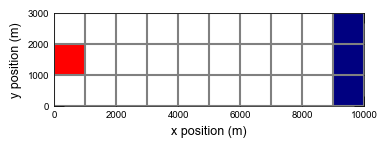

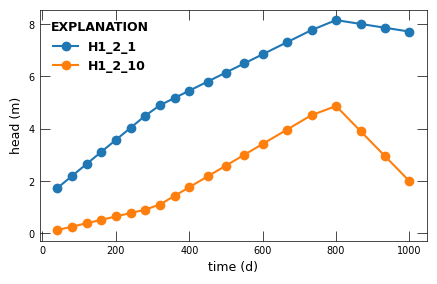

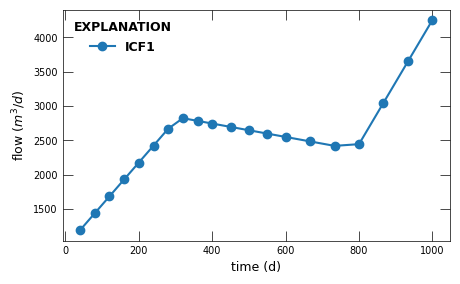

In [6]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)
scenario()